<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Построить модель со значением метрики качества *F1* не меньше 0.75. 

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyRegressor
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer 
import re 
from sklearn.metrics import f1_score

In [2]:
ds = pd.read_csv('C:/Users/alexander_bu/Documents/Progects/Text/toxic_comments.csv')
display(ds.head(10))
display(ds.tail())
ds.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В нашем распоряжении 159571 комментарий, классифицированный на признак токсичности. Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на корпусе - наборе текстов, в котором эмоции и ключевые слова уже размечены. Создадим корпус комментариев, переведём тексты в кодировку Unicode (U).

In [3]:
corpus = ds['text'].values.astype('U')
print(corpus[0:3])

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."]


Сделаем функцию для очистки и лемматизации и применим ее к корпусу комментариев:

In [4]:
def clear_lemmatize_text(text):
    
    re_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    
    lemmatizer = WordNetLemmatizer()
    lemm_text = ' '.join([lemmatizer.lemmatize(w) for w in re_text])
    
    return lemm_text

In [5]:
nltk.download('wordnet')
#TEST
print(corpus[0])
print()
print(clear_lemmatize_text(corpus[0]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexander_bu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now


In [6]:
%%time
for i in range(len(corpus)):
    corpus[i] = clear_lemmatize_text(corpus[i])
    
print(corpus[0:3])
print()

['Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now'
 'D aww He match this background colour I m seemingly stuck with Thanks talk January UTC'
 'Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info']

Wall time: 1min 50s


In [7]:
# ВАРИАНТ лемматизации с параметром POS Tag, дает более глубокую и точную обработку,
# но время обработки текста увеличивается в разы, при этом влияние на метрику F1 минимальное

# from nltk.corpus import wordnet
# nltk.download('averaged_perceptron_tagger')

# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

# def clear_lemmatize_text_(text):    
#     re_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()    
#     lemmatizer = WordNetLemmatizer()
#     lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in re_text])    
#     return lemm_text

Добавим преобразованный корпус в основной датасет

In [8]:
ds['lemm_text'] = pd.DataFrame(corpus)[0]

display(ds.head())
print()
ds.info()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159571 non-null  object
 1   toxic      159571 non-null  int64 
 2   lemm_text  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


Проверим распределение целевого признака

In [9]:
ds.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

В целевом признаке наблюдается дисбаланс. При обучении моделей необходимо будет это учесть при определении параметра class_weight.

Разделим данные на тренировочную и тестовую выборки, определим целевой признак. Чтобы при разделении сохранить пропорции меток классов установим параметр stratify метода train_test_split.

In [10]:
features_train, features_test, target_train, target_test = train_test_split(
    ds['lemm_text'], ds['toxic'], test_size=0.20, random_state=12345, stratify = ds['toxic'])

print(features_train.shape)
print(target_train.shape)
print()
print(features_test.shape)
print(target_test.shape)
print()
print('Доля положительных значений целевого признака для train:', target_train.value_counts()[1] / len(target_train))
print('Доля положительных значений целевого признака для test:', target_test.value_counts()[1] / len(target_test))

(127656,)
(127656,)

(31915,)
(31915,)

Доля положительных значений целевого признака для train: 0.10167951369305007
Доля положительных значений целевого признака для test: 0.10167632774557418


Выполним загрузку списка стоп-слов и векторизацию текста:

In [11]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexander_bu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
print(features_train[0])
print()
print(features_test[0])

  (0, 123837)	0.08794194379069332
  (0, 125722)	0.12393311887381023
  (0, 4167)	0.10495952088246104
  (0, 140895)	0.14569136761342252
  (0, 100075)	0.23670486204609442
  (0, 131967)	0.31538502209406133
  (0, 12410)	0.1904103076816997
  (0, 34706)	0.19224153525366033
  (0, 111696)	0.2642973066771396
  (0, 71269)	0.17350353165405738
  (0, 99313)	0.34609080161639305
  (0, 12595)	0.23115599237612935
  (0, 46203)	0.31721206172086225
  (0, 8269)	0.1742032798074324
  (0, 112117)	0.10242633162570712
  (0, 106133)	0.1704264970356912
  (0, 98464)	0.23206009886796655
  (0, 141259)	0.3455742570538736
  (0, 140625)	0.1926418542638018
  (0, 82598)	0.2051079249049404
  (0, 1276)	0.140804210650308

  (0, 136585)	0.22770860328538392
  (0, 133790)	0.18168519504867076
  (0, 121517)	0.2860572111620506
  (0, 115214)	0.20395722719586842
  (0, 115192)	0.3633111410620943
  (0, 87679)	0.3129997483608572
  (0, 59911)	0.34797133690054227
  (0, 59284)	0.3797983561091245
  (0, 46474)	0.2712797837402512
  (0, 22238

Данные подготовлены к обученияю и тестированию моделей.

## Обучение

Создадим сводную таблицу для сравнения результатов работы алгоритмов.

In [13]:
model_comparison = pd.DataFrame(columns=['Алгоритм', 'F1 на валидации'])
display(model_comparison)

,Алгоритм,F1 на валидации


Функция для настройки и тестирования алгоритмов

In [14]:
def  tuning_test_models(model_name, model, parameters, features, target, features_test, target_test):
    
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(features, target)
 
    best_model = grid.best_estimator_    
    best_model.fit(features, target)   
    target_predict = best_model.predict(features_test)
    
    f1 = f1_score(target_test, target_predict)
    
    print("\n========================================================")
    print(" Модель",  model_name)
    print("========================================================")
    
    print("\n Лучший результат на обучении:\n", grid.best_score_)    
    print("\n Лучшие параметры:\n", grid.best_params_)    
    print("\n Лучшая модель:\n", grid.best_estimator_)
    
    print("\n ========================================================")
        
    print("\n F1 на валидации:\n", f1)
    print("\n ========================================================")
    print()
    
    result = {'Алгоритм' : model_name,
              'F1 на валидации' : round(f1, 3)}    
    return result

Обучим модели с подбором гиперапарметров следующими алгоритмами:
- LogisticRegression
- LinearSVC
- SGDClassifier
- RandomForestClassifier

In [15]:
%%time
model_results = tuning_test_models(
                            'LogisticRegression', 
                            LogisticRegression(class_weight='balanced',
                                                random_state=12345,
                                                solver='liblinear'), 
                            {'C': [1, 3], 'penalty': ['l1', 'l2']}, 
                            features_train, 
                            target_train,
                            features_test, 
                            target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель LogisticRegression

 Лучший результат на обучении:
 0.7604999988915374

 Лучшие параметры:
 {'C': 3, 'penalty': 'l1'}

 Лучшая модель:
 LogisticRegression(C=3, class_weight='balanced', penalty='l1',
                   random_state=12345, solver='liblinear')


 F1 на валидации:
 0.7729551640166165




,Алгоритм,F1 на валидации
0,LogisticRegression,0.773


Wall time: 38.1 s


In [16]:
%%time
model_results = tuning_test_models(
                            'LinearSVC', 
                            LinearSVC(random_state=12345), 
                            {'penalty': ['l1', 'l2'],                                      
                             'max_iter': [100, 1000]}, 
                            features_train, 
                            target_train,
                            features_test, 
                            target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель LinearSVC

 Лучший результат на обучении:
 0.7633096223642027

 Лучшие параметры:
 {'max_iter': 100, 'penalty': 'l2'}

 Лучшая модель:
 LinearSVC(max_iter=100, random_state=12345)


 F1 на валидации:
 0.7815458770872784




,Алгоритм,F1 на валидации
0,LogisticRegression,0.773
1,LinearSVC,0.782


Wall time: 6.86 s


In [17]:
%%time
model_results = tuning_test_models(
                            'SGDClassifier', 
                            SGDClassifier(n_jobs=-1, random_state=12345), 
                            {'loss': ['hinge', 'squared_hinge'], 
                             'penalty':['l2','l1', 'none']}, 
                            features_train, 
                            target_train,
                            features_test, 
                            target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель SGDClassifier

 Лучший результат на обучении:
 0.7631225143713024

 Лучшие параметры:
 {'loss': 'hinge', 'penalty': 'none'}

 Лучшая модель:
 SGDClassifier(n_jobs=-1, penalty='none', random_state=12345)


 F1 на валидации:
 0.7702888583218707




,Алгоритм,F1 на валидации
0,LogisticRegression,0.773
1,LinearSVC,0.782
2,SGDClassifier,0.770


Wall time: 2min 55s


In [18]:
%%time
model_results = tuning_test_models(
                            'RandomForestClassifier', 
                            RandomForestClassifier(n_jobs=-1, random_state=12345, class_weight='balanced'), 
                            {'n_estimators': range(20, 40, 5),
                             'max_depth': range(6, 12, 2)}, 
                            features_train, 
                            target_train,
                            features_test, 
                            target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель RandomForestClassifier

 Лучший результат на обучении:
 0.3494472428712138

 Лучшие параметры:
 {'max_depth': 8, 'n_estimators': 30}

 Лучшая модель:
 RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=30,
                       n_jobs=-1, random_state=12345)


 F1 на валидации:
 0.32866789441375077




,Алгоритм,F1 на валидации
0,LogisticRegression,0.773
1,LinearSVC,0.782
2,SGDClassifier,0.770
3,RandomForestClassifier,0.329


Wall time: 2min 58s


Рассмотрим на диаграмме результаты измерения качества моделей на валидационной выборке.

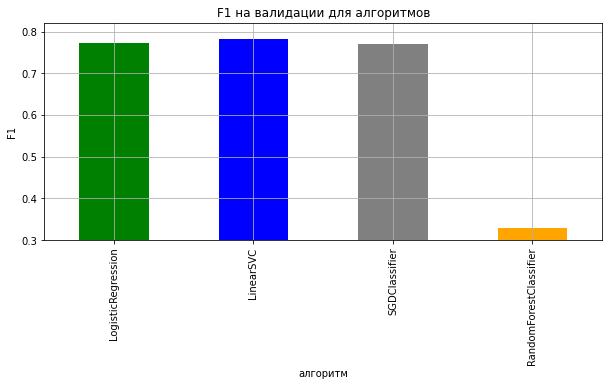

In [19]:
ax = (
        model_comparison.plot(
            x='Алгоритм',
            y='F1 на валидации',
            kind='bar',
            grid=True,
            color=["green", "blue", "gray", "orange"],
            figsize=(10, 4))
)
ax.set_title('F1 на валидации для алгоритмов')
ax.set_xlabel('алгоритм')
ax.set_ylabel('F1')
ax.legend().remove()
plt.ylim(bottom=0.3)
plt.show()

Все модели кроме RandomForestClassifier показали результат выше целевого 0,75. Лучший результат у алгоритма LinearSVC.

Проверим модель на адекватность, сравним c константной моделью

In [20]:
model_constant = DummyRegressor(strategy='constant', constant=1)

model_constant.fit(features_train, target_train)
predict_const = model_constant.predict(features_test)

f1_const = f1_score(target_test, predict_const)

print('F1 для константной модели:', f1_const)

F1 для константной модели: 0.18458475540386804


Адекватность моделей подтверждается, у всех моделей метрика выше чем у константной.

## Выводы

В результате выполнения данного проекта были построены модели для классификации комментариев на позитивные и негативные для отправки на модерацию в случае их токсичности. Для этого были проведены анализ и подготовка имеющихся данных с разметкой о токсичности правок. Различными алгоритмами, с подбором гиперпараметров, были обучены модели и протестирована их работа. Анализ полученных моделей показал, что наилучшие результаты показывает модель LinearSVC. Также с задачей обеспечить метрику качества F1 не менее 0.75 успешно справились LogisticRegression и SGDClassifier. Алгоритму RandomForestClassifier не удалось достичь нужного результата. Полученные модели прошли проверку на адекватность.